# Lab 3: Extending Logistic Regression

### Authors: *Will Lahners, Edward Powers, and Nino Castellano*
### 1) Preperation and Overview
#### 1.1) Business Use Case

Prediction Task: 
The prediction task is centered around deploying machine learning algorithms, specifically employing a logistic regression model in a one-versus-all (OvA) configuration. The primary goal is to predict whether market participants should buy, sell, or hold their positions based on daily trends observed in the data. These trends are derived from key financial indicators such as the opening price, high and low prices, and the closing price. By exploiting historical data patterns, the model aims to provide valuable insights into optimal investment actions, and such contributs to more informed decision-making in the dynamic and often unpredictable stock market environment.

Business Case:
In the contemporary financial landscape, characterized by the emergence of algorithms in day-trading, our project aims to provide a refined machine learning solution tailored for the prediction of optimal investment actions. This comprehensive software package incorporates advanced techniques, notably logistic regression, to thoroughly analyze daily stock trends. The intended user base spans a diverse array of financial entities, encompassing investment banks, standard banks, hedge funds, and direct-to-consumer platforms like Robinhood. The package could be ready to push to customers following the completion of front-end and back-end UI/UX. In the end, the software package aspires to empower users with predictive probability insights, allowing them to navigate the complexities of financial markets with heightened confidence and strategic foresight.

Model Deployment:
For the deployment phase, our chosen logistic regression model adopts a one-versus-all (OvA) approach, creating separate binary classifiers for each class (buy, sell, hold). The logistic regression model boasts a customizable regularization term (C), facilitating a delicate balance between fitting the training data closely and preventing overfitting through the penalization of large coefficients. This becomes particularly critical for the model to generalize effectively to new market conditions in the unpredictable world of finance. Having been trained on historical data, the model stands poised for deployment as a vital component of our comprehensive software package, designed to revolutionize decision-making processes within the financial domain.

#### 1.2) Data Preprocessing

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from scipy.special import expit
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


# read the CSV file
data = pd.read_csv('stockpriceforecast/data/prices.csv')

# display the first few rows of the dataframe
data.head()

Date      Open      High       Low     Close  Adj Close      Volume
0  2015-02-17  2.970060  2.997060  2.902558  2.902558   2.349932  55057948.0
1  2015-02-18  2.920559  2.979060  2.916059  2.956560   2.393652  31801480.0
2  2015-02-19  3.006061  3.006061  2.965560  2.992560   2.422798  37002206.0
3  2015-02-20  2.988060  2.988060  2.929559  2.938559   2.379078  30158007.0
4  2015-02-23  2.866558  2.889058  2.857558  2.875558   2.328072  83954148.0

Given that the dataset primarily consists of stock prices and volume, scaling may not be strictly necessary, especially if interpretability is a concern. However, scaling could still be beneficial for ensuring that all features have similar ranges and for potentially improving convergence speed.

Therefore, my recommendation would be to scale the data as a precautionary measure to ensure consistent behavior across different datasets and to potentially improve the model's performance. However, if interpretability is a top priority and you don't observe convergence issues during model training, you could choose to not scale the data.


In [17]:
print("\nData types:", data.dtypes)
print("\nMissing values:\n",data.isnull().sum())

# select numeric columns for scaling
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

# initialize scaler
scaler = StandardScaler()

# scale numeric features
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

# describe the final dataset
print("\nFinal dataset overview:")
print(data.describe())



Data types: Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

Missing values:
 Date         0
Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

Final dataset overview:
               Open          High           Low         Close     Adj Close  \
count  2.056000e+03  2.056000e+03  2.056000e+03  2.056000e+03  2.056000e+03   
mean   1.105903e-16 -1.658855e-16  1.105903e-16  2.211806e-16 -1.658855e-16   
std    1.000243e+00  1.000243e+00  1.000243e+00  1.000243e+00  1.000243e+00   
min   -7.369443e-01 -7.338389e-01 -7.615335e-01 -7.356884e-01 -6.718673e-01   
25%   -4.783748e-01 -4.747312e-01 -4.817743e-01 -4.785460e-01 -4.674504e-01   
50%   -2.856022e-01 -2.861363e-01 -2.845076e-01 -2.862686e-01 -2.840696e-01   
75%   -9.717587e-03 -2.199153e-02 -2.954564e-03 -1.290984e-02 -4.776187e-02   
max    5.374187e+00  5.199826e+00

Data Shape: The dataset contains 2057 rows and 7 columns.

Data Types: All columns except 'Date' are numeric (float64).

Missing Values: There is one missing value in each column. We'll need to handle these missing values before proceeding with further analysis.

Final Dataset Overview:

Mean: The mean of each numeric column (except 'Volume') is approximately 0, indicating that the data has been centered around zero.
Standard Deviation (std): The standard deviation of each numeric column is approximately 1, indicating that the data has been scaled to have unit variance.
Min/Max: The minimum and maximum values of each column vary, but after scaling, they're within a comparable range.

Interpretation of Scaling: By scaling the data, we've transformed the features such that they have mean 0 and standard deviation 1. This ensures that the features are on a similar scale, which can improve the performance of certain algorithms, such as logistic regression.
Scaling helps in preventing features with larger magnitudes from dominating the optimization process and ensures that the model learns the underlying patterns more effectively.
For instance, without scaling, the 'Volume' column, which has much larger values compared to the price columns, could disproportionately influence the model's predictions. Scaling mitigates this issue by putting all features on a comparable scale.
In summary, scaling the data ensures that the logistic regression model can effectively learn from all features without being biased by differences in feature magnitudes. It helps in improving model convergence and performance.

Handle Missing Values: Impute missing values with the mean of each numeric column, ensuring that the dataset is complete for analysis.

Split the Data into Training and Testing Sets: Define features (X) and the target variable (y), then split the data into training and testing sets. Here, you can choose a relevant column as the target variable. Since we are dealing with stock price prediction, you might want to predict the future close price based on historical data. Therefore, you should keep the 'Close' column as the target variable.

Discretize the Target Variable y: Since you want to predict whether to buy, sell, or hold stocks based on price movements, you need to discretize the 'Close' column into multiple classes. You can do this by categorizing the price movements into different categories (e.g., if the price increases, decreases, or remains the same). The number of bins will depend on how finely you want to categorize the price movements.

Check Unique Values: After splitting the data and discretizing the target variable, it's essential to verify the unique values in both y_test (the actual target values in the testing set) and predictions (the predicted values). This check helps ensure that the model outputs and actual targets align properly and allows for further analysis of the classification results.

So, the 'Close' column already exists in your dataset, and you'll use it as the target variable for predicting future price movements. Then, you'll discretize this column into multiple classes representing different price movements (e.g., buy, sell, hold) to perform classification.

In [18]:
# handle missing values
# impute missing values using the mean of each numeric column (all of them)
numeric_cols = data.select_dtypes(include=['float64']).columns
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())

X = data.drop(columns=['Date']) # dont need the date column for further processing
y = data['Close']  # 'Close' variable is the target variable for prediction

# discretize the target variable y
# use the cut function with 4 bins
y_bins = pd.cut(y, bins=3, labels=False)

# split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y_bins, test_size=0.2, random_state=42)

# display the shapes of the training and testing sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

# check unique values in y_test
print("Unique values in y_test:", np.unique(y_test))
# check unique values of y_bins
print("Unique values of y_bins:", np.unique(y_bins))

# Code credit to us

Training set shape: (1645, 6) (1645,)
Testing set shape: (412, 6) (412,)
Unique values in y_test: [0 1 2]
Unique values of y_bins: [0 1 2]


Training set shape: (1645, 6) (1645,)

This means that the training set contains 1645 samples (rows) and 6 features (columns). Additionally, there are 1645 target values corresponding to each sample. In other words, the training set consists of 1645 observations with 6 features each, along with their corresponding target values.
Testing set shape: (412, 6) (412,)

This means that the testing set contains 412 samples (rows) and 6 features (columns). Similarly, there are 412 target values corresponding to each sample. The testing set consists of 412 observations with 6 features each, along with their corresponding target values.
In summary, the shape of the training and testing sets indicates the number of samples (observations) and features in each set, as well as the number of target values associated with each sample. These sets are ready for use in training and evaluating a machine learning model, such as a logistic regression model, for stock price prediction.

We chose an 80/20 split for the following reasons:

Balancing Training and Testing Data: An 80/20 split is a common choice that strikes a balance between having enough data for training the model effectively and having a sufficient amount of data for evaluating its performance. With 80% of the data allocated for training, the model can learn from a substantial portion of the dataset, while the 20% testing set provides a reasonable amount of data for evaluating the model's generalization performance.

Trade-off between Bias and Variance: A larger training set (e.g., 80%) can help reduce bias by providing more data for the model to learn from, potentially leading to a more accurate model. However, a smaller testing set (e.g., 20%) can increase the variance of performance estimates, as there is less data available for evaluation. Nonetheless, in practice, an 80/20 split is often sufficient for obtaining reliable performance estimates while ensuring efficient use of data for training and testing.

Computational Efficiency: Using a smaller testing set can lead to faster model evaluation, which is advantageous when experimenting with different models or hyperparameters.

Overall, the 80/20 split is a widely used and practical choice for dividing data into training and testing sets, offering a good balance between model training and evaluation requirements. If you have specific considerations or requirements that suggest a different split ratio, feel free to adjust it accordingly.

      count      mean       std       min       25%       50%       75%  \
Bin                                                                       
0    1918.0 -0.246018  0.332366 -0.735688 -0.487813 -0.309435 -0.077774   
1      67.0  2.592541  0.562413  1.440565  2.302837  2.624581  3.069873   
2      72.0  4.141136  0.559406  3.381321  3.677325  4.019660  4.637407   

          max  
Bin            
0    1.286129  
1    3.345286  
2    5.409591  


<Figure size 800x600 with 0 Axes>

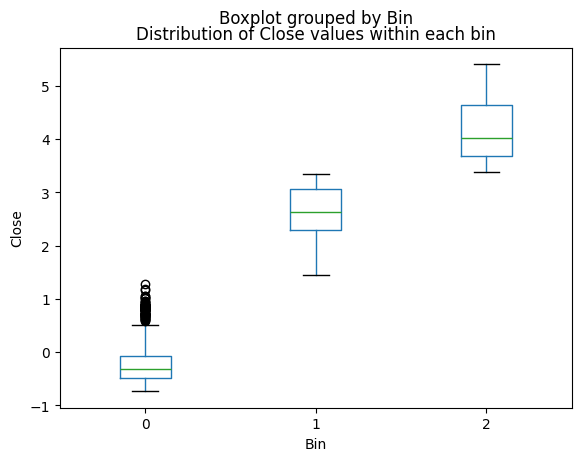

In [19]:
# combine 'Close' values with bin labels
data_with_bins = pd.concat([y, y_bins], axis=1)
data_with_bins.columns = ['Close', 'Bin']

# group data by bin labels
grouped_data = data_with_bins.groupby('Bin')

# calculate summary statistics for 'Close' values within each bin
summary_stats = grouped_data['Close'].describe()

# print summary statistics
print(summary_stats)
# box plots
plt.figure(figsize=(8, 6))
data_with_bins.boxplot(column='Close', by='Bin', grid=False)
plt.title('Distribution of Close values within each bin')
plt.xlabel('Bin')
plt.ylabel('Close')
plt.show()

# Code credit to us

Bin 0 (Low 'Close' values):

**Mean:** Approximately -0.246          **Standard deviation (std):** Approximately 0.332
Bin 0 represents periods when the stock price is relatively low. This could be considered a **potential buying opportunity** ('BUY'), as the mean 'Close' value is below average and indicates a lower price range.



Bin 1 (Moderate 'Close' values):

**Mean:** Approximately 2.593           **Standard deviation (std):** Approximately 0.562
Bin 1 represents periods when the stock price is in a moderate range. This could suggest stability, and it may be advisable to **hold onto existing positions** ('HOLD') during these periods, as the mean 'Close' value is in a moderate range.



Bin 2 (High 'Close' values):

**Mean:** Approximately 4.141           **Standard deviation (std):** Approximately 0.559
Bin 2 represents periods when the stock price is relatively high. This could be considered a **potential selling opportunity** ('SELL'), as the mean 'Close' value is above average and indicates a higher price range.

### 2) Modeling 
#### 2.1) Creating a Muilti-Class Classifier

For creating a multi-classifier we must first create a seperate Binary Classifier for each unique class. We are tasked with creating a **One-Versus-All (OvA)** classifier where the samples belonging to the class being considered are treated as positive examples, while samples from other classes are treated as negative, for each seperate Binary Classifier trained. During the prediction stages we will run an instance through each Binary Classifier, choosing the one that has the highest probability.

The following code defines a Binary Logistic Regression class that will be used to train and evaluate a multi-class classifier. It is derived from the *BinaryLogisticRegressionBase* class in eclarson's notebook *Logistic Regression.ipynb* and from the *BinaryLogisticRegression* class in his *Optimization.ipynb*. This includes a customizable regularization term C for when adjusted, affects the regularization term by regulating the trade-off between fitting the training data and keeping the model's weights small. A **higher value of C** implies less regularization, allowing the model to fit the training data more closely, potentially leading to overfitting. Conversely, a **lower value of C** increases the regularization strength, encouraging the model to generalize better to unseen data by keeping the weights smaller.  We are calculating gradient using a lower C value which is closer to **L2 reguralization** primarly to improve generalization by penalizing large coefficients, which in turn encourages the model to learn simpler patterns in the data. This is particularly important to our finacial prediction tasks, where the goal is often to generalize well to new market conditions.

In [20]:
# define the Binary Logistic Regression class
class BinaryLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.001): 
        self.eta = eta
        self.iters = iterations
        self.C = C # Adjustable C for regularization term (Using a lower C value to be closer to L2 reguralization)
        # Internally store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if hasattr(self, 'w_'):
            return 'Binary Logistic Regression Object with coefficients:\n' + str(self.w_)  # If we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'
    
    # convenience, private
    @staticmethod    
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) # 1/(1+np.exp(-theta)) 
    
    @staticmethod  
    def _add_bias(self, X):
        return np.hstack((np.ones((X.shape[0], 1)), X)) # add bias term
    
    # vectorized gradient calculation with regularization using L2 Normilization
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:] * self.C
        return gradient
    
    # public:   
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
    
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate 
            # add bacause maximizing 
            
# All credit to instructor code

Utilizing Vectorization we can speed up our model. This is because python is not fast with for loops however, using vectorization in numpy is faster becasue numpy backend is written in C++. So this following class is just extending our BinaryLogisticRegression class to a Vectorized version. This code is coming from again eclarson's notebook *Logistic Regression.ipynb*. 

In [21]:
# vectorized coding
import numpy as np
from scipy.special import expit

class VectorBinaryLogisticRegression(BinaryLogisticRegression):
    # inherit from our previous class to get same functionality
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    # but overwrite the gradient calculation
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_intercept=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        return gradient.reshape(self.w_.shape)
    
# All credit to instructor code

The following code performs  **Steepest Ascent Optimization** which is (also known as gradient ascent logistic regression) that is a method used to maximize the likelihood function of a logistic regression model by iteratively updating the model parameters (coefficients) in the direction of the gradient of the likelihood function.

In [22]:
#OPTIMIZATION METHODS IN SEPERATE CLASSES
#steepest ascent
class SteepestAscentBinaryLogisticRegression:
    def __init__(self, eta, iterations=20, C = 0.001):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.w_ = None
    
    def __str__(self):
        return 'Steepest Ascent Binary Logistic Regression Object' if hasattr(self, 'w_') else 'Untrained Steepest Ascent Binary Logistic Regression Object'
        
    def _sigmoid(self, theta):
        return expit(theta)
    
    def _add_intercept(self, X):
        return np.hstack((np.ones((X.shape[0], 1)), X))
    
    def _get_gradient(self, X, y):
        gradient = np.zeros(self.w_.shape)
        for xi, yi in zip(X, y):
            gradi = (yi - self.predict_proba(xi, add_intercept=False)) * xi
            gradient += gradi.reshape(self.w_.shape)
        
        return gradient / float(len(y))
    
    def fit(self, X, y):
        Xb = self._add_intercept(X)
        self.w_ = np.zeros((Xb.shape[1], 1))
        
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb, y)
            self.w_ += gradient * self.eta
    
    def predict_proba(self, X, add_intercept=True):
        Xb = self._add_intercept(X) if add_intercept else X
        return self._sigmoid(Xb @ self.w_)
    
    def predict(self, X):
        return (self.predict_proba(X) > 0.5)
    
# All credit to instructor code

The following code performs **Stochastic Gradient Ascent Optimization (SGA)** and was derived from eclarson's notebook *Optimization.ipynb* that is similar to the previous binary classifiers but with changes in the get_gradient calculation to ensure that optimization technique is being performed. It is a variant of gradient ascent optimization where instead of computing the gradient of the loss function with respect to the model parameters using the entire dataset, the gradient is estimated using only a single randomly chosen sample at each iteration. This makes each update step much faster, allowing for faster convergence and scalability to large datasets.

In [23]:
#stochastic gradienct ascent
class StochasticGradientAscentBinaryLogisticRegression:
    def __init__(self, eta, iterations=20, C = 0.001):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.w_ = None
    
    def __str__(self):
        return 'Stochastic Gradient Ascent Binary Logistic Regression Object' if hasattr(self, 'w_') else 'Untrained Stochastic Gradient Binary Logistic Regression Object'
        
    def _sigmoid(self, theta):
        return expit(theta)
    
    def _add_intercept(self, X):
        return np.hstack((np.ones((X.shape[0], 1)), X))
    
    # stochastic gradient calculation 
    def _get_gradient(self,X,y):
        
        # grab a subset of samples in a mini-batch
        # and calculate the gradient according to the small batch only
        mini_batch_size = 16
        idxs = np.random.choice(len(y), mini_batch_size)
        
        ydiff = y[idxs]-self.predict_proba(X[idxs],add_intercept=False).ravel() # get y difference (now scalar)
        gradient = np.mean(X[idxs] * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += 2 * self.w_[1:] * self.C  # Use a positive sign here for gradient ascent

        
        return gradient
    
    def fit(self, X, y):
        Xb = self._add_intercept(X)
        self.w_ = np.zeros((Xb.shape[1], 1))
        
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb, y)
            self.w_ += gradient * self.eta
    
    def predict_proba(self, X, add_intercept=True):
        Xb = self._add_intercept(X) if add_intercept else X
        return self._sigmoid(Xb @ self.w_)
    
    def predict(self, X):
        return (self.predict_proba(X) > 0.5)
    
# All credit to instructor code

The following code performs **Newton's Method of Optimization** and was derived from eclarson's notebook *Optimization.ipynb* that is similar to the previous binary classifiers but with changes in the get_gradient calculation to ensure that optimization technique is being performed. This method of optimization utilizes information about both the gradient (first derivative) and the curvature (second derivative) of the function to iteratively update the current solution in the direction of the minimum. Specifically, it computes the gradient and the Hessian matrix of the function at the current point and then solves a linear equation system to compute the Newton step, which represents the direction and magnitude of the update. 

In [24]:
from numpy.linalg import pinv
class NewtonsMethodBinaryLogisticRegression:
    def __init__(self, eta, iterations=20, C = 0.001):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.w_ = None
    
    def __str__(self):
        return 'Netwons Method Binary Logistic Regression Object' if hasattr(self, 'w_') else 'Untrained Netwons Method Binary Logistic Regression Object'
        
    def _sigmoid(self, theta):
        return expit(theta)
    
    def _add_intercept(self, X):
        return np.hstack((np.ones((X.shape[0], 1)), X))
    
    def fit(self, X, y):
        Xb = self._add_intercept(X)
        self.w_ = np.zeros((Xb.shape[1], 1))
        
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb, y)
            self.w_ += gradient * self.eta
    
    def predict_proba(self, X, add_intercept=True):
        Xb = self._add_intercept(X) if add_intercept else X
        return self._sigmoid(Xb @ self.w_)
    
    def predict(self, X):
        return (self.predict_proba(X) > 0.5)

    # just overwrite gradient function
    def _get_gradient(self,X,y):
        g = self.predict_proba(X,add_intercept=False).ravel() # get sigmoid value for all classes
        hessian = X.T @ np.diag(g*(1-g)) @ X - 2 * self.C # calculate the hessian

        ydiff = y-g # get y difference
        gradient = np.sum(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:] * self.C
        
        return pinv(hessian) @ gradient
    
# All credit to instructor code

Below is our custom Multi-class Losgistical Regression classifier model that checks for a solver variable indicating what optimization technique to use and also what value of regularization term C to use. 

In [25]:
# This is our MultiClass Logistic Regression Classifier 
class MultiClassLogisticRegression:
    # add in solver functionality 
    def __init__(self, eta=0.1, solver = "steepest", iterations=20, C=0.001):
        self.eta = eta
        self.solver = solver # Will default to Steepest Ascent
        self.iters = iterations
        self.C = C
        self.classifiers_ = [] # will fill this array with binary classifiers
        self.unique_ = None
        # internally we will store the weights as self.w_ to keep with sklearn conventions
        
    def __str__(self):
        if hasattr(self, 'w_'):
            return 'MultiClass Logistic Regression Object with coefficients:\n' + str(self.w_)  # If we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self, X, y):
        self.unique_ = np.unique(y) # get each unique class value 
        for yval in self.unique_: # for each unique value
            binary_y = (y == yval).astype(int) # create a binary problem 
            blr = VectorBinaryLogisticRegression(eta=self.eta, iterations=self.iters)
            
            # Checks for selected Optimization technique 
            if self.solver == "steepest":
                blr = SteepestAscentBinaryLogisticRegression(self.eta, self.iters)
            elif self.solver == 'stochastic':
                blr = StochasticGradientAscentBinaryLogisticRegression(self.eta, self.iters)
            elif self.solver == 'newton':
                blr = NewtonsMethodBinaryLogisticRegression(self.eta, self.iters)
            else:
                raise ValueError("Invalid solver. Choose from 'steepest', 'stochastic', or 'newton'.") 
               
            blr.fit(X, binary_y)
            self.classifiers_.append(blr)
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self, X):
        probs = []
        for blr in self.classifiers_:
            probs.append(blr.predict_proba(X).reshape(-1, 1))
        return np.hstack(probs)
    
    def predict(self, X):
        return self.unique_[np.argmax(self.predict_proba(X), axis=1)]    

# All credit to instructor code

### 2.2) Training the Classifiers

In [26]:
%%time
# train the logistic regression model
y_train = np.array(y_train)
y_test= np.array(y_test)
X_train=np.array(X_train)
X_test=np.array(X_test)

# steepest optimization
mlr = MultiClassLogisticRegression(0.1,"steepest", iterations=20, C=0.001)
mlr.fit(X_train,y_train)
print(mlr)

yhat = mlr.predict(X_test)
print('Accuracy of  Steepest: ',accuracy_score(y_test,yhat))

# Code credit to us

MultiClass Logistic Regression Object with coefficients:
[[ 0.68407631 -0.206199   -0.20691555 -0.20525336 -0.20610745 -0.20555559
  -0.13508474]
 [-0.74896053  0.05854832  0.05884454  0.0592076   0.05913433  0.06071316
   0.06567282]
 [-0.74631305  0.11166411  0.11171535  0.11071754  0.11128949  0.10963519
   0.04504739]]
Accuracy of  Steepest:  0.9514563106796117
CPU times: total: 281 ms
Wall time: 558 ms


In [27]:
%%time
# stochastic optimization
mlr = MultiClassLogisticRegression(0.1,"stochastic", iterations=20, C=0.001)
mlr.fit(X_train,y_train)
print(mlr)

yhat = mlr.predict(X_test)
print('Accuracy of Stochastic: ',accuracy_score(y_test,yhat))

# Code credit to us

MultiClass Logistic Regression Object with coefficients:
[[ 0.67556642 -0.22071228 -0.21978171 -0.22126147 -0.22060449 -0.21899453
  -0.10013717]
 [-0.770162    0.00180454  0.00367207  0.00120593  0.00389451  0.00589133
   0.07018992]
 [-0.7397896   0.11691657  0.11366906  0.11518986  0.1113853   0.1130377
   0.00162591]]
Accuracy of Stochastic:  0.9466019417475728
CPU times: total: 0 ns
Wall time: 12.8 ms


In [28]:
%%time

# Newtons's optimization
X_train_10, _, y_train_10, _ = train_test_split(X_train, y_train, test_size=0.5, random_state=42)
mlr = MultiClassLogisticRegression(0.1,"newton", iterations=10, C=0.001)
mlr.fit(X_train_10,y_train_10)
print(mlr)

yhat = mlr.predict(X_test)
print('Accuracy of Newton: ',accuracy_score(y_test,yhat))

# Code credit to us

MultiClass Logistic Regression Object with coefficients:
[[ 1.34668688 -0.17553361 -1.6314581   1.08645609 -0.3554137   0.42759085
  -0.06458488]
 [-1.43346681 -1.1985089   1.53058773  1.65040043 -2.07408541  0.25926779
   0.13966311]
 [-1.42924582  1.079577   -0.02653013 -2.23368935  2.16600519 -0.4982785
  -0.07728812]]
Accuracy of Newton:  0.9684466019417476
CPU times: total: 15.6 ms
Wall time: 103 ms


### 2.3) Comparing Our Classifiers Performance to SKL's Performance

In [37]:
%%time
from sklearn.linear_model import LogisticRegression as SKLogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

lr_sk = SKLogisticRegression(solver='liblinear') # all params default

lr_sk.fit(X_train,y_train)
print(np.hstack((lr_sk.intercept_[:,np.newaxis],lr_sk.coef_)))
yhat = lr_sk.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

# All credit to instructor code

[[ 5.60218398 -0.72941015 -0.77467328 -0.69198064 -0.77118997 -0.50339523
  -0.47102669]
 [-4.17893124 -0.19797841 -0.63703954  0.53415124 -0.2251684   1.27734906
   0.3875452 ]
 [-6.08121836  0.28182667  0.65799789  0.06381749  0.64641916  0.253786
  -0.06476408]]
Accuracy of:  0.970873786407767
CPU times: total: 0 ns
Wall time: 0 ns


In [34]:
%%time
# Newtons's optimization Our best optimization method.
X_train_10, _, y_train_10, _ = train_test_split(X_train, y_train, test_size=0.5, random_state=42)
mlr = MultiClassLogisticRegression(0.1,"newton", iterations=10, C=0.001)
mlr.fit(X_train_10,y_train_10)
print(mlr)

yhat = mlr.predict(X_test)
print('Accuracy of Newton: ',accuracy_score(y_test,yhat))

MultiClass Logistic Regression Object with coefficients:
[[ 1.34668688 -0.17553361 -1.6314581   1.08645609 -0.3554137   0.42759085
  -0.06458488]
 [-1.43346681 -1.1985089   1.53058773  1.65040043 -2.07408541  0.25926779
   0.13966311]
 [-1.42924582  1.079577   -0.02653013 -2.23368935  2.16600519 -0.4982785
  -0.07728812]]
Accuracy of Newton:  0.9684466019417476
CPU times: total: 31.2 ms
Wall time: 78.1 ms


Comparing the scikit-learn model to our implementations are pretty much night and day. The scikit-learn model produced a slightly higher accuracy of **0.9708** compared to the Newton's method, which produced an accuracy of **0.9684**. However, the time difference is what really made the scikit-learn model more superior to our best model, as it classified our training and testing data at faster CPU times for a majority of conducted trials in which we tested the comparison. 

This time difference can be explained due paralellization, which is handled much better through scikit-learn as the operations are all performed in lower level C++. The accuracy can also be explained because the lr_sk object we created uses regularization, which controls over-learning. This optimization allows scikit-learn to process our data in much finer steps. 

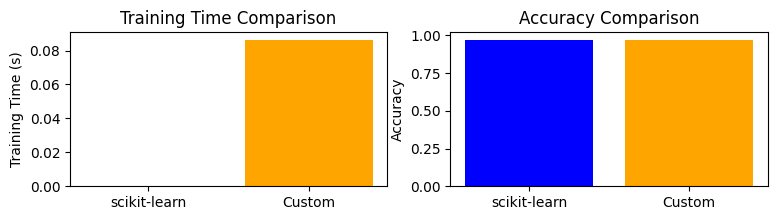

Scikit-learn Training Time: 0.0
Custom Training Time: 0.08642411231994629
Scikit-learn Accuracy: 0.970873786407767
Custom Accuracy: 0.9684466019417476


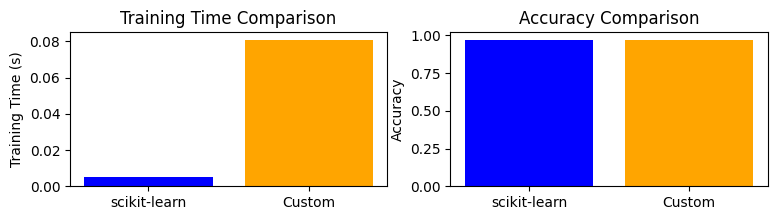

Scikit-learn Training Time: 0.004909038543701172
Custom Training Time: 0.08092069625854492
Scikit-learn Accuracy: 0.970873786407767
Custom Accuracy: 0.9684466019417476


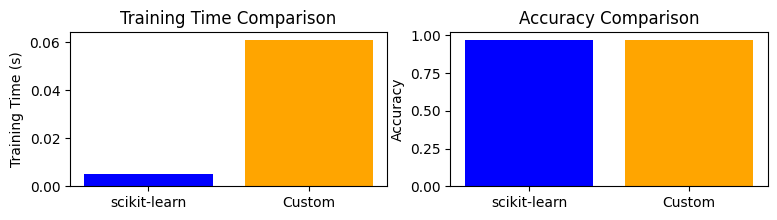

Scikit-learn Training Time: 0.005011081695556641
Custom Training Time: 0.06098127365112305
Scikit-learn Accuracy: 0.970873786407767
Custom Accuracy: 0.9684466019417476


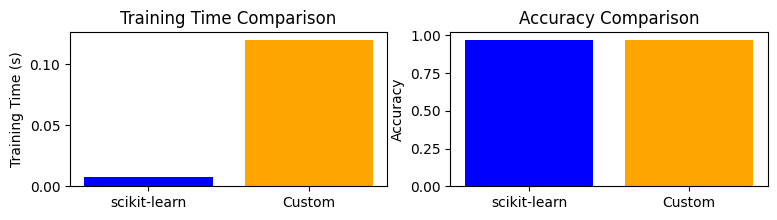

Scikit-learn Training Time: 0.007224321365356445
Custom Training Time: 0.11999750137329102
Scikit-learn Accuracy: 0.970873786407767
Custom Accuracy: 0.9684466019417476


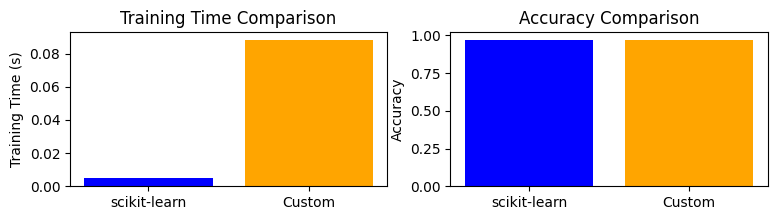

Scikit-learn Training Time: 0.005041360855102539
Custom Training Time: 0.08840727806091309
Scikit-learn Accuracy: 0.970873786407767
Custom Accuracy: 0.9684466019417476


In [38]:
import time 
for i in range(5):
    # Train logistic regression model using scikit-learn
    start_time_sklearn = time.time()
    lr_sk = SKLogisticRegression(solver='liblinear')
    lr_sk.fit(X_train, y_train)
    end_time_sklearn = time.time()
    sklearn_training_time = end_time_sklearn - start_time_sklearn

    # Measure classification performance using scikit-learn model
    yhat_sk = lr_sk.predict(X_test)
    accuracy_sk = accuracy_score(y_test, yhat_sk)

    # Train custom logistic regression model using Newton's method
    start_time_custom = time.time()
    mlr_custom = MultiClassLogisticRegression(0.1, "newton", iterations=10, C=0.001)
    mlr_custom.fit(X_train_10, y_train_10)
    end_time_custom = time.time()
    custom_training_time = end_time_custom - start_time_custom

    # Measure classification performance using custom model
    yhat_custom = mlr_custom.predict(X_test)
    accuracy_custom = accuracy_score(y_test, yhat_custom)

    # Plotting
    labels = ['scikit-learn', 'Custom']
    training_times = [sklearn_training_time, custom_training_time]
    accuracies = [accuracy_sk, accuracy_custom]

    fig, ax = plt.subplots(1, 2, figsize=(9, 2))

    ax[0].bar(labels, training_times, color=['blue', 'orange'])
    ax[0].set_title('Training Time Comparison')
    ax[0].set_ylabel('Training Time (s)')

    ax[1].bar(labels, accuracies, color=['blue', 'orange'])
    ax[1].set_title('Accuracy Comparison')
    ax[1].set_ylabel('Accuracy')

    plt.show()

    print("Scikit-learn Training Time:", sklearn_training_time)
    print("Custom Training Time:", custom_training_time)
    print("Scikit-learn Accuracy:", accuracy_sk)
    print("Custom Accuracy:", accuracy_custom)
    
# Credits to Chat GPT for helping us generate the plots.

The code above allows us to see a more visual representation of our comparison results. The test is run 5 times to see how the performance tests differ each time the classifiers are run. Regarding accuracy, this seemed to stay consistent throughout with scikit-learn's 0.9708 and our custom build using Newtons optimization producing a 0.9684. The training time results show a strong indication of how significantly faster scikit-learn is compared to our custom model. The times for scikit-learn differ on each iteration through the training of the classifier but still are relatively low and holds true to its title of being the fastest model.

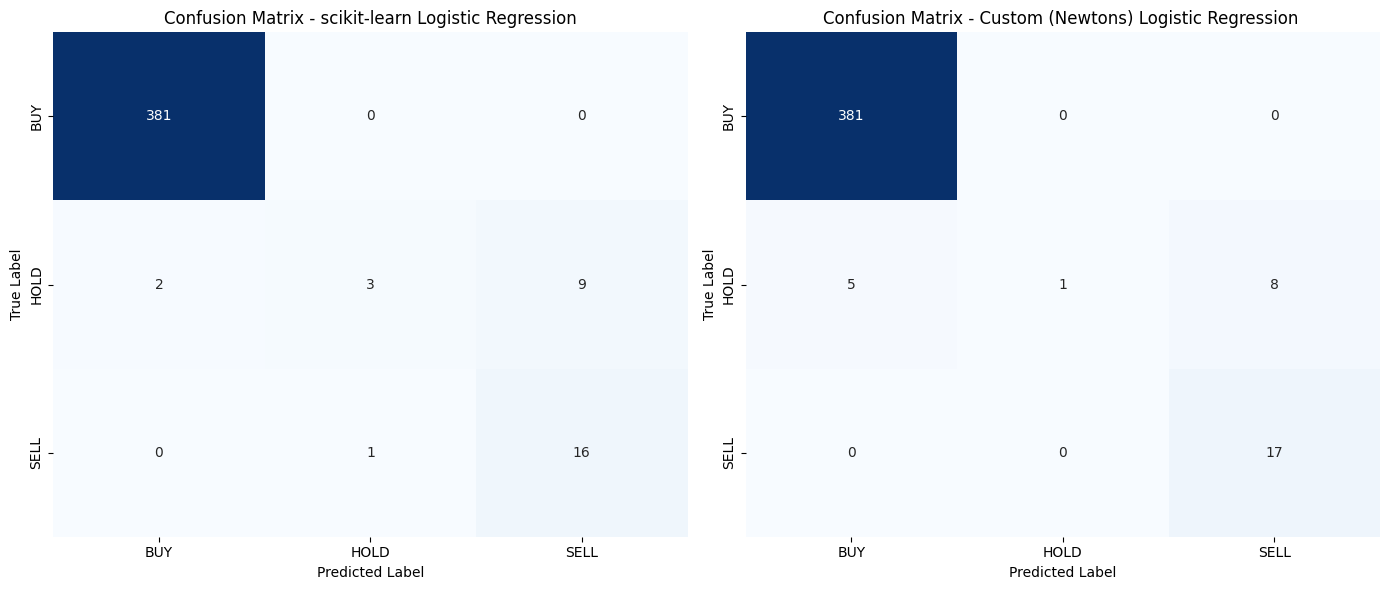

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Define class labels
class_labels = ['BUY','HOLD','SELL']

# Compute confusion matrix for scikit-learn logistic regression
cm_sk = confusion_matrix(y_test, yhat_sk)

# Compute confusion matrix for custom logistic regression
cm_custom = confusion_matrix(y_test, yhat_custom)

# Plot confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm_sk, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax[0],xticklabels=class_labels, yticklabels=class_labels)
ax[0].set_title('Confusion Matrix - scikit-learn Logistic Regression')
ax[0].set_xlabel('Predicted Label')
ax[0].set_ylabel('True Label')

sns.heatmap(cm_custom, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax[1],xticklabels=class_labels, yticklabels=class_labels)
ax[1].set_title('Confusion Matrix - Custom (Newtons) Logistic Regression ')
ax[1].set_xlabel('Predicted Label')
ax[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

# Credits to Chat GPT for helping us generate the plots.

The code and plots above show the confusion matrix for our predictions and what their true labels were. Given that our testing data consists of 412 samples, we can visualize what labels exactly were predicted from running the test data on the models after training. The boxes that make up the diagonal represent correct predictions, which is where the majority of the counts on the plots lie which explains the high accuracy on both models. The boxes on the outside of the diagonal represent incorrect predictions, but not terribly incorrect given there are incorrect predictions for buying when it should be a sell and vice versa which would be concerning for our business purposes of maximizing profit through the buying and selling of stocks. Most of the incorrect predictions lie around or along the diagonal, which can be explained by certain stock prices being close to the thresholds set by logistic regression that of being labeled as a HOLD when it was very close to either the buy or sell threshold created when training the classifier.

## 3) Deployment

### 3.1) Implementation Suggestion

For deployment of our model in real-world situations, we believe it would be best to use the **scikit-learn model**, as it is the most interpretable way to classify data. 

The scikit-learn model essentially compacts all of our previous logistic regression code and packages it in a library that can be utilized in just four lines of code. Scikit-learn's logistic regression implementation is optimized for processing datasets of various sizes. Even with our current dataset of 1645 training records and 412 testing records, scikit-learn's efficient processing ensures fast model training and prediction. Additionally, should our dataset grow larger in the future, scikit-learn's scalability ensures constant performance without compromising speed, like our custom models.

Scikit-learn's widespread adoption into many different languages ensures access to further documentation should anything break in the future. With our custom implementation, detecting an error can be pearlous and can cost future developers or a team maintaining our model a lot of unnecessary time. 

## 4) Exceptional Work

### 4.1) Pre-processing for use with a "one-versus-one" classifier
Let's now focus on creating a "one-versus-one" classifier that we can use with SKLearn's LogisticRegression lib module. The goal of this specific classifer to use use binary classifiation amoung one target variable that contains two classes, in our case we will use the 'Close' column as our target variable like we did previously for multi-class classification. However, rather than having three classes, we are going to stick with two classes, simply "BUY" or "SELL", rather than including "HOLD". 

We followed nearly the same steps for pre-processing this data, however, we created a new column called "Next_Close" that will include the label "BUY" or "SELL", rather than creating 3 different bins. Here is how we pre-processed the data and created a new dataframe for use with our LogisticRegression classifier. 

In [41]:
# updating the existing data variable
data = pd.read_csv('stockpriceforecast/data/prices.csv')

# computer target variable based on price change
data['Next_Close'] = data['Close'].shift(-1)  # Next day's closing price
data['Target'] = np.where(data['Next_Close'] > data['Close'], 'BUY', 'SELL')

# preprocess further
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
scaler = StandardScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

X = data.drop(columns=['Date', 'Next_Close', 'Target'])  # drop unnecessary columns

# impute missing values using  the mean of the column
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
X = pd.DataFrame(X_imputed, columns=X.columns)

# need to encode using one-hot '1' or '0' for buy/sell
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['Target'])

# split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# show the shapes of the training and testing sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

# create the Logistic Regression model
logistic_reg_sklearn = LogisticRegression()
# fit the model on the training data
logistic_reg_sklearn.fit(X_train, y_train)

# predict on the testing data
y_pred_sklearn = logistic_reg_sklearn.predict(X_test)
accuracy_sklearn = accuracy_score(y_test, y_pred_sklearn)
print("Accuracy (using sklearn's LogisticRegression):", accuracy_sklearn)



Training set shape: (1645, 6) (1645,)
Testing set shape: (412, 6) (412,)
Accuracy (using sklearn's LogisticRegression): 0.5315533980582524


As we can see from the output of this classifier, it is difficult to get promising results because we realitically need another variable to fully determine if we should "BUY" or "SELL". Simply training off of one variable, in our case the "Close" variable, is not enough data for this binary classifier. However, our previous above implementation of our multi-class logistic regression classifier handled this variable much better, due to having an extra class for "HOLD". 

To improve this accuracy, we could opt for much better feature representation, as the features we are using for this example may not be sufficiently informative for predicting the target variable alone. Feature engineering or incorporating additional features could possibly improve this model's performance. We could also opt for better evalutation metrics, such as precision, recall, or even F-1 score, which would possibly provide a more better depiction of our model's performance.